# Import Required Libraries

In [18]:

!pip install numpy pandas obspy scikit-learn matplotlib scipy


Defaulting to user installation because normal site-packages is not writeable


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# Load Seismic Data
The dataset could contain time_abs (absolute time), time_rel (relative time), and velocity(m/s) columns.

In [20]:
df = pd.read_csv('./training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv')

# Convert absolute time to datetime
# df['time_abs'] = pd.to_datetime(df['time_abs'])

# Display the first few rows of data
print(df.head())


  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-03-25T00:00:00.440000       0.000000  -5.481780e-15
1     1970-03-25T00:00:00.590943       0.150943  -6.878653e-15
2     1970-03-25T00:00:00.741887       0.301887  -7.486137e-15
3     1970-03-25T00:00:00.892830       0.452830  -7.191481e-15
4     1970-03-25T00:00:01.043774       0.603774  -6.287278e-15


# Bandpass Filter to Remove Noise
Apply a bandpass filter to focus on seismic signals within a frequency range

In [21]:
# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Sampling rate (based on time intervals)
time_intervals = df['time_rel(sec)'].diff().dropna()
sampling_rate = 1 / time_intervals.mean()

# Apply bandpass filter between 0.01 Hz and 0.5 Hz
filtered_velocity = apply_bandpass_filter(df['velocity(m/s)'], lowcut=0.01, highcut=0.5, fs=sampling_rate)


### Visualization of Filtered Seismic Velocity Over Time

The following plot represents the seismic velocity data after applying a bandpass filter to isolate relevant seismic signals. The x-axis represents the relative time (in seconds), and the y-axis shows the velocity values (in meters per second). This plot helps us visualize the filtered data, which is cleaned up by removing high-frequency noise and low-frequency trends.

A grid is applied to make it easier to read the plot and observe changes in velocity over time.

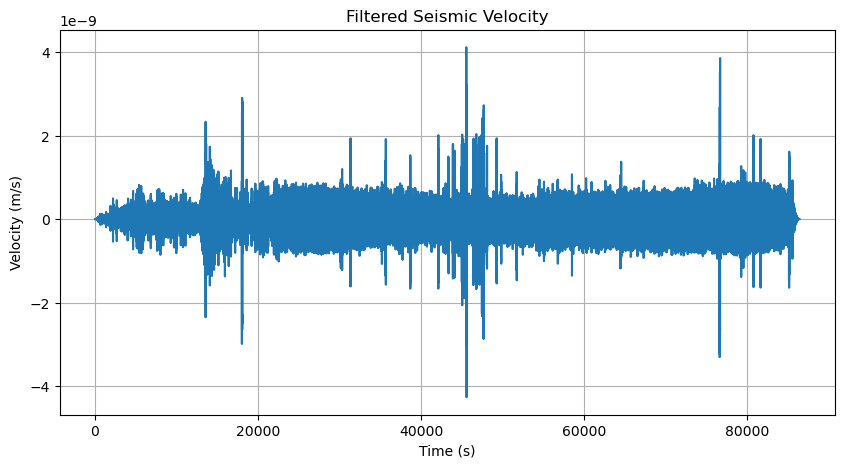

In [22]:
# Plot the filtered data
plt.figure(figsize=(10, 5))
plt.plot(df['time_rel(sec)'], filtered_velocity)
plt.title('Filtered Seismic Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.show()

# TA/LTA Algorithm for Event Detection
The STA/LTA algorithm can help detect seismic events

In [23]:
# STA/LTA parameters (window size in seconds)
sta_window = 1  # Short-term average window
lta_window = 10  # Long-term average window

# Convert STA/LTA windows into samples
nsta = int(sta_window * sampling_rate)
nlta = int(lta_window * sampling_rate)

# Compute the STA/LTA characteristic function
cft = classic_sta_lta(filtered_velocity, nsta, nlta)


### Visualization of STA/LTA Characteristic Function

The following plot illustrates the **STA/LTA (Short-Term Average/Long-Term Average)** characteristic function, which is a critical component in detecting seismic events within the noisy data. The x-axis represents the relative time (in seconds), and the y-axis shows the STA/LTA ratio.

The STA/LTA method compares the short-term average energy of the seismic signal to the long-term average energy. A higher STA/LTA ratio indicates potential seismic events, making this plot useful for identifying when seismic signals occur amid noise.



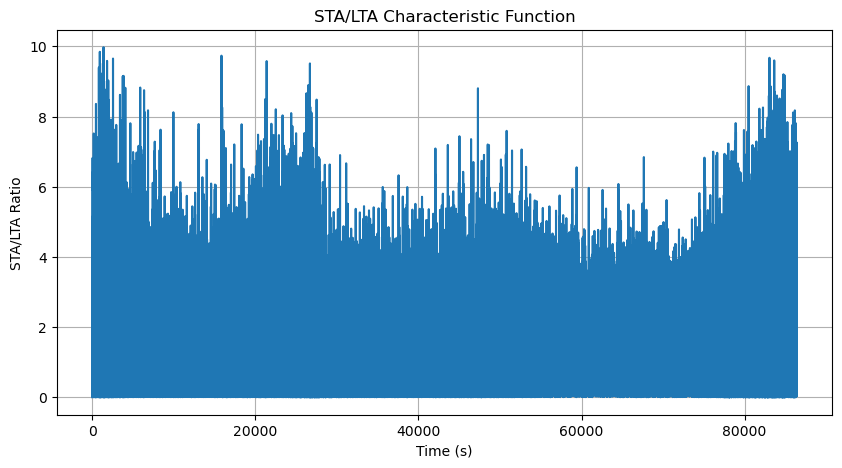

In [24]:
# Plot the STA/LTA characteristic function
plt.figure(figsize=(10, 5))
plt.plot(df['time_rel(sec)'], cft)
plt.title('STA/LTA Characteristic Function')
plt.xlabel('Time (s)')
plt.ylabel('STA/LTA Ratio')
plt.grid(True)
plt.show()


### Event Detection Using STA/LTA Ratio

In this section, we utilize the **STA/LTA (Short-Term Average/Long-Term Average)** ratio to identify potential seismic events in the filtered seismic data. The process involves setting thresholds for the STA/LTA ratio to determine when a seismic event starts and ends.

- **Thresholds**:
  - `sta_lta_trigger_on = 3.5`: This threshold indicates the point at which a seismic event is considered to have started when the STA/LTA ratio exceeds this value.
  - `sta_lta_trigger_off = 1.0`: This threshold indicates the point at which the seismic event is considered to have ended when the STA/LTA ratio drops below this value.

The detected events are then marked on the plot with vertical lines representing the start and end of each event.



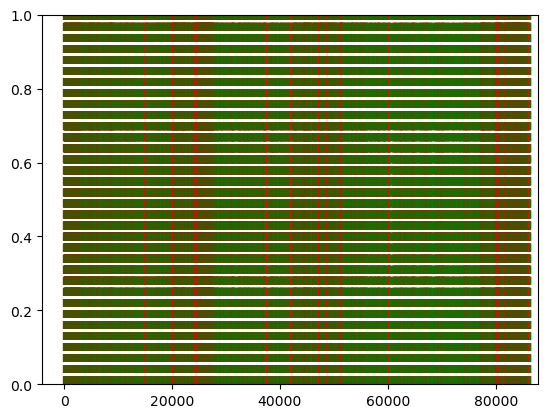

In [25]:
# Detect events based on STA/LTA ratio thresholds
sta_lta_trigger_on = 3.5   # Start of event
sta_lta_trigger_off = 1.0  # End of event
events = trigger_onset(cft, sta_lta_trigger_on, sta_lta_trigger_off)

# Mark detected events
for event in events:
    start_time = df['time_rel(sec)'][event[0]]
    end_time = df['time_rel(sec)'][event[1]]
    plt.axvline(x=start_time, color='red', linestyle='--', label='Event Start')
    plt.axvline(x=end_time, color='green', linestyle='--', label='Event End')

# Machine Learning Model for Signal Classification
Using a Random Forest classifier to separate noise from seismic signals. First, label the data, extract features (amplitude, energy, etc.), and train a model.

In [26]:
df.head()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-03-25T00:00:00.440000,0.000000,-5.481780e-15
1,1970-03-25T00:00:00.590943,0.150943,-6.878653e-15
2,1970-03-25T00:00:00.741887,0.301887,-7.486137e-15
3,1970-03-25T00:00:00.892830,0.452830,-7.191481e-15
4,1970-03-25T00:00:01.043774,0.603774,-6.287278e-15


In [36]:
# Create labels: 1 for signal (based on detected events), 0 for noise
df['label'] = 0
for event in events:
    df.loc[event[0]:event[1], 'label'] = 1

# Feature Engineering
df['amplitude'] = df['velocity(m/s)'].abs()
window_size = 100  # Adjust window size as needed
df['energy'] = df['velocity(m/s)'].rolling(window_size).apply(lambda x: np.sum(x**2), raw=True)

# Drop rows with any NaN values in the entire DataFrame
df_clean = df.dropna(subset=['amplitude', 'energy', 'label'])

# Select features and labels from the cleaned DataFrame
X = df_clean[['amplitude', 'energy']]
y = df_clean['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Visualizing Class Distribution

In [ ]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(6, 4))
df_clean['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution (Noise vs Signal)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Noise (0)', 'Signal (1)'], rotation=0)
plt.grid(True)
plt.show()


In [38]:
# Check the distribution of labels
print(df['label'].value_counts())

label
0    525306
1     47105
Name: count, dtype: int64


In [35]:
# Train Random Forest Classifier with class weights
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 10})
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_prob = clf.predict_proba(X_test)[:, 1]
custom_threshold = 0.4
y_pred = (y_prob >= custom_threshold).astype(int)

# Print classification report with zero_division parameter
print(classification_report(y_test, y_pred, zero_division=1))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


label
0    525306
1     47105
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    157700
           1       0.08      1.00      0.15     13994

    accuracy                           0.08    171694
   macro avg       0.54      0.50      0.08    171694
weighted avg       0.93      0.08      0.01    171694

Accuracy: 8.15%


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


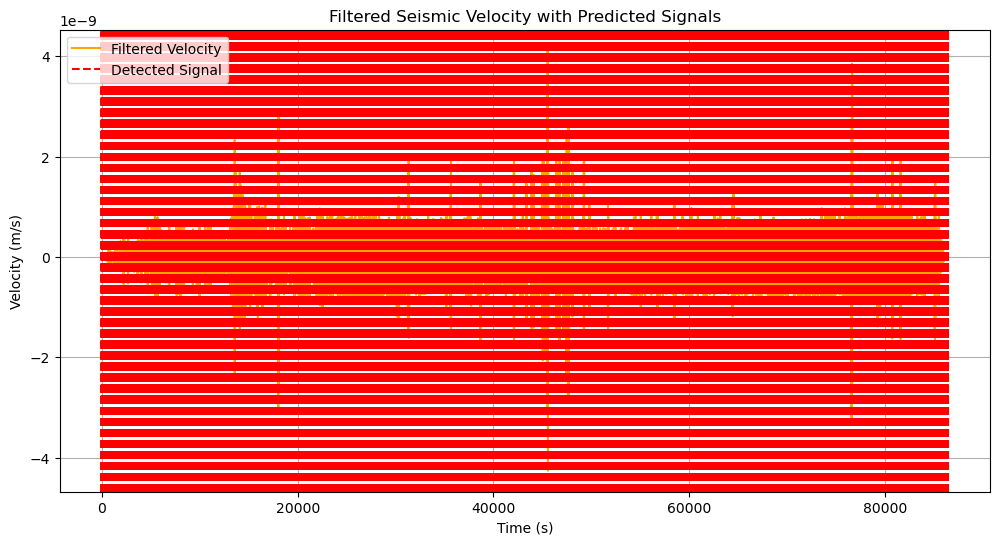

In [41]:
# Create a DataFrame to hold predictions and actual values
df['predicted_label'] = 0  # Initialize predicted labels in the original DataFrame
df.loc[X_test.index, 'predicted_label'] = y_pred  # Assign predicted labels

# Plot the filtered velocity data
plt.figure(figsize=(12, 6))
plt.plot(df['time_rel(sec)'], filtered_velocity, label='Filtered Velocity', color='orange')
plt.title('Filtered Seismic Velocity with Predicted Signals')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

# Mark detected signals on the plot
signal_indices = df[df['predicted_label'] == 1].index
for idx in signal_indices:
    plt.axvline(x=df['time_rel(sec)'][idx], color='red', linestyle='--', label='Detected Signal' if idx == signal_indices[0] else "")

plt.legend()
plt.grid(True)
plt.show()


# Only Transmit Useful Data
Use the classifier to filter out noise and transmit only the segments of data classified as signal.

In [32]:
# Filter the dataset for signal data
signal_data = df[df['label'] == 1]

# Export the signal data to CSV (to simulate transmission back to Earth)
signal_data.to_csv('signal_data_to_transmit.csv', index=False)
